In [ ]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import datasets,transforms, models
import math
import sys
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from utils import gabor_kernel
from params import generate_gabor_param
from Resnet50backend import Bottleneck

##dogs dataset

In [ ]:
import zipfile
file_dir = '/content/drive/My Drive/毕设阶段三/train_dogs.zip'  # 你的压缩包路径
zipFile = zipfile.ZipFile(file_dir)
for file in zipFile.namelist():
    zipFile.extract(file, '/content')  # 解压路径
zipFile.close()

import zipfile
file_dir = '/content/drive/My Drive/毕设阶段三/val_dogs.zip'  # 你的压缩包路径
zipFile = zipfile.ZipFile(file_dir)
for file in zipFile.namelist():
    zipFile.extract(file, '/content')  # 解压路径
zipFile.close()

['0', '1', '2', '3', '4']
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
['0', '4', '1', '4', '2', '3', '2', '4', '1', '0', '0', '1', '4', '3', '2', '2', '3', '1', '3', '3', '3', '1', '2', '2', '1', '0', '4', '2', '0', '0', '2', '4']


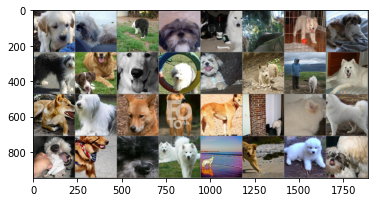

In [ ]:


transform = transforms.Compose([transforms.CenterCrop(234),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

traindir = "/content/train_dogs"
valdir = "/content/val_dogs"
train = datasets.ImageFolder(traindir, transform)
val = datasets.ImageFolder(valdir, transform)
train_loader = torch.utils.data.DataLoader(
    train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val, batch_size=32, shuffle=True)

classes = train.classes
classes_index = train.class_to_idx
print(classes)
print(classes_index)

X_train, y_train = next(iter(train_loader))
mean = [0.5,0.5,0.5]
std  = [0.5,0.5,0.5]
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))
img = img*std+mean

print([classes[i] for i in y_train])
plt.imshow(img)

##compressBank

In [ ]:
class CompressB(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = (stride, stride)
        #self.padding = (kernel_size // 2, kernel_size // 2)
        self.padding = 'same'#input and output have the same shape, all pad with 0

        # Param instatiations
        self.weight = torch.zeros((out_channels, in_channels, kernel_size, kernel_size))


    def forward(self, x):
        return F.conv2d(x, self.weight, None, self.stride, self.padding)

    def initialize(self, sigma_theta, theta, LR_theta, LRfilter_num):
        theta = torch.tensor(theta)
        LR_theta = torch.tensor(LR_theta)
        if LRfilter_num != 8:
            print("error: This compress bank desighed for 512-8 channels compression")
        
        for i in range(self.out_channels):     
            for j in range(self.in_channels):
                if np.abs(LR_theta[i]-theta[j]) > np.pi/16.0:
                      self.weight[i, j] = torch.zeros((self.kernel_size, self.kernel_size))
                else:
                      self.weight[i, j] = torch.ones((self.kernel_size, self.kernel_size))*torch.exp(-(LR_theta[i]-theta[j])**2/(2*sigma_theta**2))              
                self.weight[i][torch.isnan(self.weight[i])] = 0
                self.weight[i] = self.weight[i]/torch.sum(self.weight[i])#normalize to integrate to 1, for each output channel(each filter kernel)
            
                
                
        self.weight = nn.Parameter(self.weight, requires_grad=False)
        
        print(self.weight.shape)

##V1block 

based on paper https://doi.org/10.1101/2020.06.16.154542

In [ ]:
class Identity(nn.Module):
    def forward(self, x):
        return x


class GFB(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=4):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size)
        self.stride = (stride, stride)
        #self.padding = (kernel_size // 2, kernel_size // 2)
        self.padding = 'valid'

        # Param instatiations
        self.weight = torch.zeros((out_channels, in_channels, kernel_size, kernel_size))


    def forward(self, x):
        return F.conv2d(x, self.weight, None, self.stride, self.padding)

    def initialize(self, sf, theta, sigx, sigy, phase):
        
        for i in range(self.out_channels):
           
            self.weight[i, 0] = gabor_kernel(frequency=sf[i], sigma_x=sigx[i], sigma_y=sigy[i],
                                                             theta=theta[i], offset=phase[i], ks=self.kernel_size[0])
            if torch.sum(self.weight[i][0]) != 0:#sum=0
                positive = (self.weight[i][0]>0)*self.weight[i][0]
                positive = positive/torch.sum(positive)
                negative = (self.weight[i][0]<0)*self.weight[i][0]
                negative = -negative/torch.sum(negative)
                self.weight[i][0] = positive + negative      
            self.weight[i][torch.isnan(self.weight[i])] = 0
        self.weight = nn.Parameter(self.weight, requires_grad=False)
        
        print(self.weight.shape)




In [ ]:
class VOneBlock(nn.Module):
    def __init__(self, sf, theta, sigx, sigy, phase, LR_theta,
                 k_exc=25, noise_mode='neuronal', noise_scale=0.32, noise_level=0.07,
                 simple_channels=256, complex_channels=256, out_channels = 8, ksize=11, stride=2, input_size=224):
        super().__init__()

        self.in_channels = 3

        self.simple_channels = simple_channels
        self.complex_channels = complex_channels
        self.out_channels_1 = self.simple_channels + self.complex_channels
        self.out_channels = out_channels
        self.stride = stride
        self.input_size = input_size

        self.sf = sf
        self.theta = theta
        self.sigx = sigx
        self.sigy = sigy
        self.phase = phase
        self.k_exc = k_exc
        self.LR_theta = LR_theta

        self.set_noise_mode(noise_mode, noise_scale, noise_level)
        self.fixed_noise = True#fixed

        self.simple_conv_q0 = GFB(self.in_channels, self.out_channels_1, ksize, stride)
        self.simple_conv_q1 = GFB(self.in_channels, self.out_channels_1, ksize, stride)
        self.simple_conv_q0.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase)
        self.simple_conv_q1.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi / 2)
        
        self.compressfilter = CompressB(self.out_channels_1, self.out_channels, 1, 1)
        self.compressfilter.initialize(sigma_theta=0.5, theta = self.theta, LR_theta = self.LR_theta, LRfilter_num = self.out_channels)

        self.simple = nn.ReLU(inplace=False)
        self.complex = Identity()
        self.gabors = Identity()
        self.noise = nn.ReLU(inplace=False)
        #self.output = Identity()
        

    def forward(self, x):
        # Gabor activations [Batch, out_channels, H/stride, W/stride]
        x = self.nonlinear(x)
        # Noise [Batch, out_channels, H/stride, W/stride]
        # V1 Block output: (Batch, out_channels, H/stride, W/stride)
        x = self.output(x)
        return x
    
    '''def groupnorm(x):
        N, C, H, W = x.shape
        x = x.view(N * G, -1)

        mean = x.mean(1, keepdim=True)
        var = x.var(1, keepdim=True)
        x = (x - mean)/(var + eps).sqrt()

        x = x.view([N, C, H, W])

        return gamma*x + beta'''
                

    def nonlinear(self, x):
        s_q0 = self.simple_conv_q0(x)
        s_q1 = self.simple_conv_q1(x)
        c = self.complex(torch.sqrt(s_q0[:, self.simple_channels:, :, :] ** 2 +
                                    s_q1[:, self.simple_channels:, :, :] ** 2) / np.sqrt(2))
        s = self.simple(s_q0[:, 0:self.simple_channels, :, :])
        return self.gabors(torch.cat((s, c), 1))

    def output(self, x):
        x = self.compressfilter(x)
        x = x/x.max()
        return self.gabors(x)



In [ ]:
'''V1 = VOneBlock(sf = frequency, theta = theta, sigx = sigma_x, sigy= sigma_y, phase= offset, LR_theta= LR_theta)
V1output = V1(input_ima)'''

##long-range filter

In [ ]:
def longrange_kernel(theta = 0, a = 20, r_max = 4, sigma = 4.0, ks=11): 

 
    a = np.pi*a/180.0 
    w = ks // 2
    grid_val = torch.arange(-w, w+1, dtype=torch.float)
    x, y = torch.meshgrid(grid_val, grid_val)
    

    fi = (x != 0)*np.arctan(y/x)+ (x == 0)*np.pi/2#-pi/2~pi/2
    fi = fi+np.pi/2#rotate 90deg
    dfi = np.abs(theta-fi)
    dfi = np.abs(dfi - (dfi//np.pi)*np.pi)
    dfi = np.abs(dfi//(np.pi/2)*np.pi - dfi)#夹角
    r = np.sqrt(x**2+y**2)
 
    #B_ang
    B_ang = np.abs((dfi <= a/2)*np.cos(2*np.pi/(2*a)*dfi))
    B_ang[torch.isnan(B_ang)] = 0

    #B_rad
    B_rad = np.abs(1.0*(r<=r_max) + (r>r_max)*torch.exp(-(r-r_max)**2/(2*sigma)))
    B_rad[torch.isnan(B_rad)] = 0

    #B
    B = B_ang*B_rad
    B[torch.isnan(B)] = 0
    B = B/torch.sum(B)#normalize to integrate to 1    
    return B

In [ ]:
class ExcitatoryFB(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = (stride, stride)
        self.padding = (kernel_size // 2, kernel_size // 2)
        #self.padding = 'same'#input and output have the same shape, all pad with 0

        # Param instatiations
        self.weight = torch.zeros((out_channels, in_channels, kernel_size, kernel_size))


    def forward(self, x):
        return F.conv2d(x, self.weight, None, self.stride, self.padding)

    def initialize(self, theta, open_angle, r_max, r_variance):
        for i in range(self.out_channels):       
            self.weight[i, i] = longrange_kernel(theta = theta[i], a = open_angle, r_max = r_max, sigma = r_variance, ks=self.kernel_size)
        self.weight = nn.Parameter(self.weight, requires_grad=False)
        
        print(self.weight.shape)

##Inhibitory filter

In [ ]:
def inhibitory_kernel(sigma = 1, ks = 5):  

    w = ks // 2
    grid_val = torch.arange(-w, w+1, dtype=torch.float)
    x, y = torch.meshgrid(grid_val, grid_val)

    g = torch.exp(-0.5 * (x ** 2 / sigma ** 2 + y ** 2 / sigma ** 2))
    g /= (2 * np.pi * sigma**2)

    return g


class InhibitoryFB(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = (stride, stride)
        self.padding = (kernel_size // 2, kernel_size // 2)#padding (int, tuple or str, optional)Padding added to all four sides of the input.
        #self.padding = 'same'#input and output have the same shape, all pad with 0

        # Param instatiations
        self.weight = torch.zeros((out_channels, in_channels, kernel_size, kernel_size))


    def forward(self, x):
        if type(x) == int:
            return 0
        else:
            return F.conv2d(x, self.weight, None, self.stride, self.padding)

    def initialize(self, sigma_theta, sigma_sur, theta, only_spatial=False, only_orientation=False):
        theta = torch.tensor(theta)

        if only_spatial == False and only_orientation == False:
            for i in range(self.out_channels):
                for j in range(self.in_channels):
                    self.weight[i, j] = inhibitory_kernel(sigma = sigma_sur, ks=self.kernel_size) * torch.exp(-torch.min((theta[i]-theta[j])**2,(np.pi-abs(theta[i]+theta[j]))**2)/(2*sigma_theta**2))                
                self.weight[i][torch.isnan(self.weight[i])] = 0
                self.weight[i] = self.weight[i]/torch.sum(self.weight[i])#normalize to integrate to 1, for each output channel(each filter kernel)

        elif only_orientation == False and only_spatial == True:
            for i in range(self.out_channels):
                for j in range(self.in_channels):
                    self.weight[i, j] = inhibitory_kernel(sigma = sigma_sur, ks=self.kernel_size)
                self.weight[i][torch.isnan(self.weight[i])] = 0
                self.weight[i] = self.weight[i]/torch.sum(self.weight[i])#normalize to integrate to 1, for each output channel(each filter kernel)

        elif only_orientation == True and only_spatial == False:
            self.weight = torch.ones((out_channels, in_channels, kernel_size, kernel_size))
            for i in range(self.out_channels):
                for j in range(self.in_channels):
                    self.weight[i, j] *=  torch.exp(-(theta[i]-theta[j])**2/(2*sigma_theta**2))/(2 * np.pi * sigma_theta**2)
                self.weight[i][torch.isnan(self.weight[i])] = 0
                self.weight[i] = self.weight[i]/torch.sum(self.weight[i])#normalize to integrate to 1, for each output channel(each filter kernel)

        else:
            self.weight = torch.ones((out_channels, in_channels, kernel_size, kernel_size))
            print("Error: This InhibitoryFB should not exist")
        
        self.weight = nn.Parameter(self.weight, requires_grad=False)
        
        print(self.weight.shape)

##recurrent block params

In [ ]:
def response(alpha, beta, gamma, eta, exci_input, inhi_input): #shunting interaction response

    P = exci_input
    Q = inhi_input
    n=2
    return (beta*P**n - eta*Q**n) / (alpha**n + gamma* (P**n+Q**n))

#0.2, 1, 1, 0.5    

In [ ]:
channels_num = 8

#Inhibit kernel
Inhi_stride = 1
Inhi_ksize_G =11
Inhi_ksize_S = 13
Inhi_ksize_D = 13

sigma_theta_G = 0.5
sigma_theta_S = 0.5
sigma_theta_D = 0.5
sigma_sur_G = 2.5
sigma_sur_S = 3
sigma_sur_D = 3

#spatial kernel for r_D
spatial_ksize_D = 5
spatial_stride_D = 1
sigma_spatial_D  = 1

#LR filter
Exci_ksize = 23
Exci_stride = 1
open_angle = 30
r_max = 8
r_variance = 4


##save filters

In [ ]:
Longfilter = ExcitatoryFB(channels_num, channels_num, Exci_ksize, Exci_stride)
Longfilter.initialize(theta = LR_theta, open_angle = open_angle, r_max = r_max, r_variance = r_variance)
#torch.save(Longfilter.weight, "/content/drive/My Drive/Longfilter_8")
Longfilter = Longfilter.cuda()

In [ ]:
spatialfilter_D_5 = InhibitoryFB(channels_num, channels_num, kernel_size=5, stride=1)
spatialfilter_D_5.initialize(sigma_theta=1, sigma_sur=1, theta = LR_theta,  only_spatial = True)
#torch.save(spatialfilter_D_5.weight, "/content/drive/My Drive/spatialfilter_D_5_8")
spatialfilter_D_5 = spatialfilter_D_5.cuda()

In [ ]:
Inhibitfilter_11 = InhibitoryFB(channels_num, channels_num, 11, 1)
Inhibitfilter_11.initialize(sigma_theta=0.5, sigma_sur=2.5, theta = LR_theta)
#torch.save(Inhibitfilter_11.weight, "/content/drive/My Drive/Inhibitfilter_11_8")
Inhibitfilter_11 = Inhibitfilter_11.cuda()

In [ ]:
Inhibitfilter_13 = InhibitoryFB(channels_num, channels_num, 13, 1)
Inhibitfilter_13.initialize(sigma_theta=0.5, sigma_sur=3.0, theta = LR_theta)
#torch.save(Inhibitfilter_13.weight, "/content/drive/My Drive/Inhibitfilter_13_8")
Inhibitfilter_13 = Inhibitfilter_13.cuda()

torch.Size([8, 8, 13, 13])


In [ ]:
Inhibitfilter_G = Inhibitfilter_11
Inhibitfilter_S = Inhibitfilter_13
Inhibitfilter_D = Inhibitfilter_13

##defination

In [ ]:
def res_G(channels_num, r_D, r_G, V1block_output,       
        alpha_G, beta_G, gamma_G, eta_G):
    P = V1block_output * (1+r_D)
    P = P/P.max()
    Q = Inhibitfilter_G(r_G)
    res = response(alpha_G, beta_G, gamma_G, eta_G, P, Q)
    res[res<0]=0
    res = res/res.max()#scale to [0,1]
    return res

In [ ]:
def res_S(channels_num, theta, r_G, r_S,
        alpha_S, beta_S, gamma_S, eta_S):
    
    P = r_G + Longfilter(r_G)
    P = P/P.max()
    Q = Inhibitfilter_S(r_S)
    res = response(alpha_S, beta_S, gamma_S, eta_S, P, Q)
    res[res<0]=0
    res = res/res.max()#scale to [0,1]
    return res

In [ ]:
def res_D(channels_num, r_S, r_D,      
        alpha_D, beta_D, gamma_D, eta_D):
    P = spatialfilter_D_5(r_S)
    P = P/P.max()
    Q = Inhibitfilter_D(r_D)
    res = response(alpha_D, beta_D, gamma_D, eta_D, P, Q)
    res[res<0]=0
    res = res/res.max()#scale to [0,1]
    return res

##recurrent block

In [ ]:
class ReBlock(nn.Module):
    def __init__(self, theta, LR_theta, in_channels = 8, out_channels = 8,
                 noise_mode='neuronal', k_exc = 25, noise_scale=0.32, noise_level=0.07,
                 loop = 2):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        # V1 param
        self.theta = theta
        #long range filter
        self.LR_theta = LR_theta
        self.ks_LR = 23
        self.open_angle = 30
        self.r_max = 8
        self.r_variance = 4

        #inhibit filter
        Inhibitfilter_G = Inhibitfilter_11
        Inhibitfilter_S = Inhibitfilter_13
        Inhibitfilter_D = Inhibitfilter_13

        #shunting normalization
        self.alpha = 0.2
        self.beta = 1.0
        self.gamma = 1.0
        self.eta = 0.2
        self.recurrent_loop = loop        

        self.output = Identity()


    def forward(self, x):
        
        x = self.iter_loop(x)

        x = self.output(x)
        return x
    

    def iter_loop(self, x):
        r_G = res_G(self.out_channels, 0, 0, x*2, 1, 1, 0, 0 )#r_d=0,thus V1out*2
        r_S = res_S(self.out_channels, self.theta, r_G, 0, 1, 1, 0, 0)
        r_D = res_D(self.out_channels, r_S, 0,  1, 1, 0, 0 )
        for i in range (self.recurrent_loop):
            r_G = res_G(self.out_channels, r_D, r_G, x, self.alpha, self.beta, self.gamma, self.eta)
            r_S = res_S(self.out_channels, self.theta, r_G, r_S, self.alpha, self.beta, self.gamma, self.eta )#final output
            r_D = res_D(self.out_channels, r_S, r_D, self.alpha, self.beta, self.gamma, self.eta )

        return self.output(r_S)




##Recurrent block output

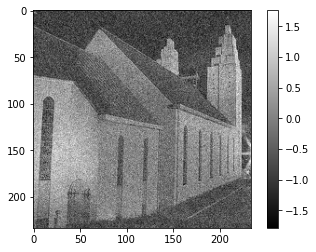

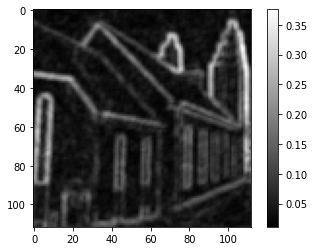

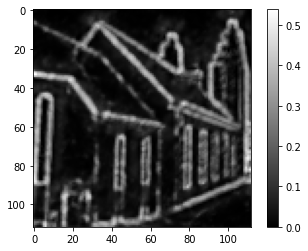

In [ ]:
#n=3
#plot_ima(input_ima[n][0])#input image under noise, noise scale=0.25, image in range [-1, 1]
#plot_ima(torch.sum(V1output[n]/8.0,0))#output after V1block
#plot_ima(torch.sum(Reoutput[n]/8.0,0))#output after recurrent block with two cycles

##Net

In [ ]:

def V1ReNet(sf_corr=0.75, sf_max=6, sf_min=0, rand_param=False, gabor_seed=0,
            simple_channels=256, complex_channels=256, LR_channels=8, loop = 2,
            noise_mode='neuronal', noise_scale=0.32, noise_level=0.07, k_exc=25,
            model_arch='resnet50', image_size=224, visual_degrees=8, ksize=11, stride=2,
            num_classes = 5
            ):



    V1_channels = simple_channels + complex_channels
    V2out_channels = LR_channels

    sf, theta, phase, nx, ny = generate_gabor_param(V1_channels, gabor_seed, rand_param, sf_corr, sf_max, sf_min)
    LR_theta = np.linspace(0,np.pi, LR_channels, endpoint= False)

    ppd = image_size / visual_degrees
    sf = sf / ppd
    sigx = nx / sf
    sigy = ny / sf
    theta = theta/180 * np.pi
    phase = phase / 180 * np.pi

    vone_block = VOneBlock(sf=sf, theta=theta, sigx=sigx, sigy=sigy, phase=phase, LR_theta = LR_theta,
                           k_exc=k_exc, noise_mode=noise_mode, noise_scale=noise_scale, noise_level=noise_level,
                           simple_channels=simple_channels, complex_channels=complex_channels, out_channels = LR_channels,
                           ksize=ksize, stride=stride, input_size=image_size)
    s2_block = ReBlock(theta = theta, LR_theta = LR_theta, in_channels = V2out_channels, out_channels = V2out_channels, 
                      noise_mode=noise_mode, k_exc = k_exc, noise_scale=noise_scale, noise_level=noise_level,
                      loop=loop)

    if model_arch:
        bottleneck = nn.Conv2d(V2out_channels, 64, kernel_size=1, stride=1, bias=False)
        nn.init.kaiming_normal_(bottleneck.weight, mode='fan_out', nonlinearity='relu')
        if model_arch.lower() == 'resnet50':
          model_back_end = ResNetBackEnd


        model = nn.Sequential(OrderedDict([
            ('vone_block', vone_block),
            ('reccurent_block', s2_block),
            ('bottleneck', bottleneck),
            ('model', model_back_end)
        ]))
    else:
        model = vone_block

    model.image_size = image_size
    model.visual_degrees = visual_degrees
    model.gabor_params = gabor_params
    model.arch_params = arch_params

    return model

##resnetbackend
Based on https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

In [ ]:
class My_ResNet50(nn.Module):
 
    def __init__(self, block, layers, num_classes=5):
        self.inplanes = 64
        super(My_ResNet50, self).__init__()
        #self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
        #                       bias=False)
        #self.bn1 = nn.BatchNorm2d(64)
        #self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])#新的
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.newfc = nn.Linear(512 * block.expansion, num_classes)
 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
 
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
 
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
 
        return nn.Sequential(*layers)
 
    def forward(self, x):
        #x = self.conv1(x)
        #x = self.bn1(x)
        #x = self.relu(x)
        #x = self.maxpool(x)
 
        x = self.layer1(x)#新的参数
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
 
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.newfc(x)
 
        return x

In [ ]:
resnet50 = models.resnet50(pretrained=True)
ResNetBackEnd = My_ResNet50(Bottleneck, [3, 4, 6, 3])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
pretrained_dict = resnet50.state_dict()
model_dict = ResNetBackEnd.state_dict()
pretrained_dict =  {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
ResNetBackEnd.load_state_dict(model_dict)
# print(resnet50)

<All keys matched successfully>

##model

In [ ]:
V = V1ReNet()

In [ ]:
model = V

In [ ]:
#learning rate decay
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum=0.9,weight_decay = 0.0001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8,10], gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7,9], gamma=0.1)

##PGD adversarial attack
https://github.com/bethgelab/foolbox

In [ ]:

!pip3 install foolbox==3.1.1
import foolbox as fb

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 180 kB 69.8 MB/s 
     |████████████████████████████████| 62 kB 993 kB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:

model.eval()

In [ ]:
bounds = (0, 1)
fmodel = fb.PyTorchModel(model, bounds=bounds)


In [ ]:
from foolbox import PyTorchModel, accuracy, samples

In [ ]:
clean_acc = accuracy(fmodel, input_ima.cuda(), l.cuda())
print(f"clean accuracy:  {clean_acc * 100:.1f} %")

clean accuracy:  100.0 %


##V1ReNet on dogs dataset

In [ ]:
#model.load_state_dict(torch.load('/content/drive/My Drive/V12_square_dogs.pkl'))

<All keys matched successfully>

In [ ]:
attack = fb.attacks.LinfPGD()#V12square dogs
epsilons = 0.1
for i in val_loader:
    input_ima,l = i
    raw_advs, clipped_advs, success = attack(fmodel, input_ima.cuda(), l.cuda(), epsilons=epsilons)
    robust_accuracy = 1 - success.float().mean(axis=-1)
    print(robust_accuracy)

tensor(0.3438, device='cuda:0')
tensor(0.3750, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.3438, device='cuda:0')
tensor(0.0938, device='cuda:0')
tensor(0.2812, device='cuda:0')
tensor(0.4062, device='cuda:0')
tensor(0.4375, device='cuda:0')
tensor(0.5312, device='cuda:0')
tensor(0.6562, device='cuda:0')
tensor(0.4062, device='cuda:0')
tensor(0.5625, device='cuda:0')
tensor(0.3750, device='cuda:0')
tensor(0.5312, device='cuda:0')
tensor(0.3125, device='cuda:0')
tensor(0.5000, device='cuda:0')


In [ ]:
a=0.3438+0.3750+0.5+0.3438+0.0938+0.2812+0.4062+0.4375+0.5312+0.6562+0.4062+0.5625+0.3750+0.5312+0.3125+0.5
a=a/16.0
a

0.41600625

In [ ]:
attack = fb.attacks.LinfPGD()#V12square dogs
epsilons = 0.05
for i in val_loader:
    input_ima,l = i
    raw_advs, clipped_advs, success = attack(fmodel, input_ima.cuda(), l.cuda(), epsilons=epsilons)
    robust_accuracy = 1 - success.float().mean(axis=-1)
    print(robust_accuracy)

tensor(0.3125, device='cuda:0')
tensor(0.4688, device='cuda:0')
tensor(0.4688, device='cuda:0')
tensor(0.4688, device='cuda:0')
tensor(0.4062, device='cuda:0')
tensor(0.4062, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.3125, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.7188, device='cuda:0')
tensor(0.3125, device='cuda:0')
tensor(0.3500, device='cuda:0')


In [ ]:
a=0.3125+0.4688+0.4688+0.4688+0.4062+0.4062+0.2500+0.625+0.5+0.5938+0.5938+0.5938+0.3125+0.3125+0.7188+0.35
a=a/16.0
a

0.46134375

In [ ]:
attack = fb.attacks.LinfPGD()#V12square dogs
epsilons = 0.05
for i in val_loader:
    input_ima,l = i
    raw_advs, clipped_advs, success = attack(fmodel, input_ima.cuda(), l.cuda(), epsilons=epsilons)
    robust_accuracy = 1 - success.float().mean(axis=-1)
    print(robust_accuracy)

tensor(0.4062, device='cuda:0')
tensor(0.3125, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(0.5625, device='cuda:0')
tensor(0.4375, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.4375, device='cuda:0')
tensor(0.5312, device='cuda:0')
tensor(0.4688, device='cuda:0')
tensor(0.5625, device='cuda:0')
tensor(0.5312, device='cuda:0')
tensor(0.3750, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5500, device='cuda:0')


In [ ]:
(0.4062+0.3125+0.5000+0.5938+0.6250+0.5625+0.4375+0.4375+0.5938+0.5312+0.4688+0.5625+0.5312+0.3750+0.5+0.5)/16.0

0.49609375

In [ ]:
attack = fb.attacks.LinfPGD()#V12square dogs
epsilons = 0.01
for i in val_loader:
    input_ima,l = i
    raw_advs, clipped_advs, success = attack(fmodel, input_ima.cuda(), l.cuda(), epsilons=epsilons)
    robust_accuracy = 1 - success.float().mean(axis=-1)
    print(robust_accuracy)

tensor(0.6562, device='cuda:0')
tensor(0.6562, device='cuda:0')
tensor(0.7188, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.5625, device='cuda:0')
tensor(0.7188, device='cuda:0')
tensor(0.6562, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.5625, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.7188, device='cuda:0')
tensor(0.6000, device='cuda:0')


In [ ]:
(0.6562+0.6562+0.7188+0.6875+0.6875+0.5625+0.7188+0.6562+0.5938+0.5938+0.5625+0.6875+0.5938+0.5938+0.7188+0.6)/16.0

0.64298125

In [ ]:
attack = fb.attacks.LinfPGD()#V12square dogs
epsilons = 0.2
for i in val_loader:
    input_ima,l = i
    raw_advs, clipped_advs, success = attack(fmodel, input_ima.cuda(), l.cuda(), epsilons=epsilons)
    robust_accuracy = 1 - success.float().mean(axis=-1)
    print(robust_accuracy)


tensor(0.0938, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.3125, device='cuda:0')
tensor(0.1562, device='cuda:0')
tensor(0.3125, device='cuda:0')
tensor(0.1562, device='cuda:0')
tensor(0.2188, device='cuda:0')
tensor(0.1562, device='cuda:0')
tensor(0.1562, device='cuda:0')
tensor(0.5312, device='cuda:0')
tensor(0.0625, device='cuda:0')
tensor(0.0312, device='cuda:0')
tensor(0.0312, device='cuda:0')
tensor(0.2812, device='cuda:0')
tensor(0.4500, device='cuda:0')


In [ ]:
(0.0938+0.25+0.5+0.3125+0.3125+0.1562+0.1562+0.1562+0.1562+0.2188+0.5312+0.0625+0.0312+0.0312+0.2812+0.4500)/16.0

0.23123125000000005